# เชียงราย

In [ ]:
!pip -q install earthengine-api geemap google-cloud-storage google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
auth.authenticate_user()

import ee, geemap
ee.Authenticate()
ee.Initialize(project='*******')


In [ ]:
import ee, datetime
# AOI: เชียงราย
aoi = ee.Geometry.Rectangle([98.9, 18.9, 99.9, 19.7])

start_date = '2025-02-01'
end_date   = '2025-05-15'


In [ ]:
worldcover = ee.Image('ESA/WorldCover/v200/2021').eq(40)
dynworld   = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
              .filterDate(start_date, end_date)
              .filterBounds(aoi)
              .select('label').mode().eq(1))
cropland = worldcover.Or(dynworld).selfMask()

In [ ]:
def s2_clean(start, end, geom):
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterDate(start, end).filterBounds(geom))
    def mask_cloud(i):
        qa = i.select('QA60')
        cloud = qa.bitwiseAnd(1<<10).Or(qa.bitwiseAnd(1<<11))
        return i.updateMask(cloud.Not()).divide(10000)
    return s2.map(mask_cloud).median().clip(geom)

def nbr(img):
    return img.normalizedDifference(['B8','B12']).rename('NBR')

pre  = s2_clean('2025-01-15','2025-01-31', aoi)
post = s2_clean(start_date, end_date, aoi)

dNBR = nbr(pre).subtract(nbr(post)).rename('dNBR').updateMask(cropland)
burn  = dNBR.gt(0.30).selfMask()
heavy = dNBR.gt(0.50).selfMask()


In [ ]:
scale = 20
polys = (burn.reduceToVectors(
            geometry=aoi, scale=scale, geometryType='polygon',
            labelProperty='burn', maxPixels=1e13)
         .map(lambda f: f.set({
             'date': end_date,
             'class': 'burn',
             'area_ha': f.geometry().area(1).divide(10000)
         })))

polys_heavy = (heavy.reduceToVectors(
            geometry=aoi, scale=scale, geometryType='polygon',
            labelProperty='heavy', maxPixels=1e13)
         .map(lambda f: f.set({
             'date': end_date,
             'class': 'heavy',
             'area_ha': f.geometry().area(1).divide(10000)
         })))

polys_all = polys.merge(polys_heavy)


In [ ]:
Map = geemap.Map(center=[19.31, 99.34], zoom=10)
Map.addLayer(dNBR, {'min':0, 'max':0.8, 'palette':['white','orange','red']}, 'dNBR')
Map.addLayer(burn,  {'palette':['#ffd400']}, 'Burn')
Map.addLayer(heavy, {'palette':['#ff00ff']}, 'Heavy')
Map.addLayerControl(); Map


Map(center=[19.31, 99.34], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Korat NDVI GIF

In [1]:
!pip -q install earthengine-api geemap

from google.colab import auth
auth.authenticate_user()

import ee, geemap
ee.Authenticate()
ee.Initialize(project='robloxidtee')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.1 MB/s eta 0:00:00


In [4]:
START_DATE = '2024-01-01'
END_DATE   = '2024-12-31'

FPS = 2
GIF_WIDTH = 768

NDVI_VIZ = {
    'min': 0.0, 'max': 1.0,
    'palette': [
        '#d73027','#f46d43','#fdae61','#fee08b',
        '#d9ef8b','#a6d96a','#66bd63','#1a9850'
    ]
}


In [3]:
gaul = ee.FeatureCollection('FAO/GAUL/2015/level1')
aoi  = gaul.filter(
    ee.Filter.And(
        ee.Filter.eq('ADM0_NAME', 'Thailand'),
        ee.Filter.eq('ADM1_NAME', 'Nakhon Ratchasima')
    )
).geometry()

Map = geemap.Map()
Map.centerObject(aoi, 8)
Map.addLayer(aoi, {}, 'AOI - Nakhon Ratchasima')
Map


Map(center=[14.955482094410225, 102.11242347721006], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# QA60: 10 = clouds, 11 = cirrus
CLOUD_BIT = 10
CIRRUS_BIT = 11

def mask_s2_sr(img):
    qa60 = img.select('QA60')
    cloud_mask = qa60.bitwiseAnd(1 << CLOUD_BIT).eq(0)
    cirrus_mask = qa60.bitwiseAnd(1 << CIRRUS_BIT).eq(0)

    scl = img.select('SCL')
    bad_scl = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))
    scl_mask = bad_scl.Not()

    mask = cloud_mask.And(cirrus_mask).And(scl_mask)

    scaled = img.select(['B2','B3','B4','B8','SCL']).addBands(qa60).divide(
        ee.Image([10000,10000,10000,10000,1,1])
    )
    return img.updateMask(mask)

def to_ndvi(img):
    ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
    ndvi = ndvi.focal_median(radius=30, units='meters')
    return ndvi.copyProperties(img, img.propertyNames())


In [6]:
start = ee.Date(START_DATE)
end   = ee.Date(END_DATE)

months = ee.List.sequence(0, end.difference(start, 'month').subtract(1))

def monthly_composite(m):
    m = ee.Number(m)
    start_m = start.advance(m, 'month')
    end_m   = start_m.advance(1, 'month')

    col = (S2
           .filterBounds(aoi)
           .filterDate(start_m, end_m)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
           .map(mask_s2_sr)
           .map(to_ndvi))

    size = col.size()
    def mk():
        img = col.median().clip(aoi)\
             .set('system:time_start', start_m.millis())
        return img

    return ee.Algorithms.If(size.gt(0), mk(), None)

img_list = months.map(monthly_composite).filter(ee.Filter.notNull(['system:time_start']))
monthly_ic = ee.ImageCollection(img_list)
monthly_ic.size().getInfo()


11

In [9]:
Map = geemap.Map()
Map.centerObject(aoi,8)
first = ee.Image(monthly_ic.first())
Map.addLayer(first, {'min':0, 'max':1, 'palette': NDVI_VIZ['palette']}, 'NDVI first month')
Map.addLayer(aoi, {}, 'AOI', False)
Map


Map(center=[14.955482094410225, 102.11242347721006], controls=(WidgetControl(options=['position', 'transparent…

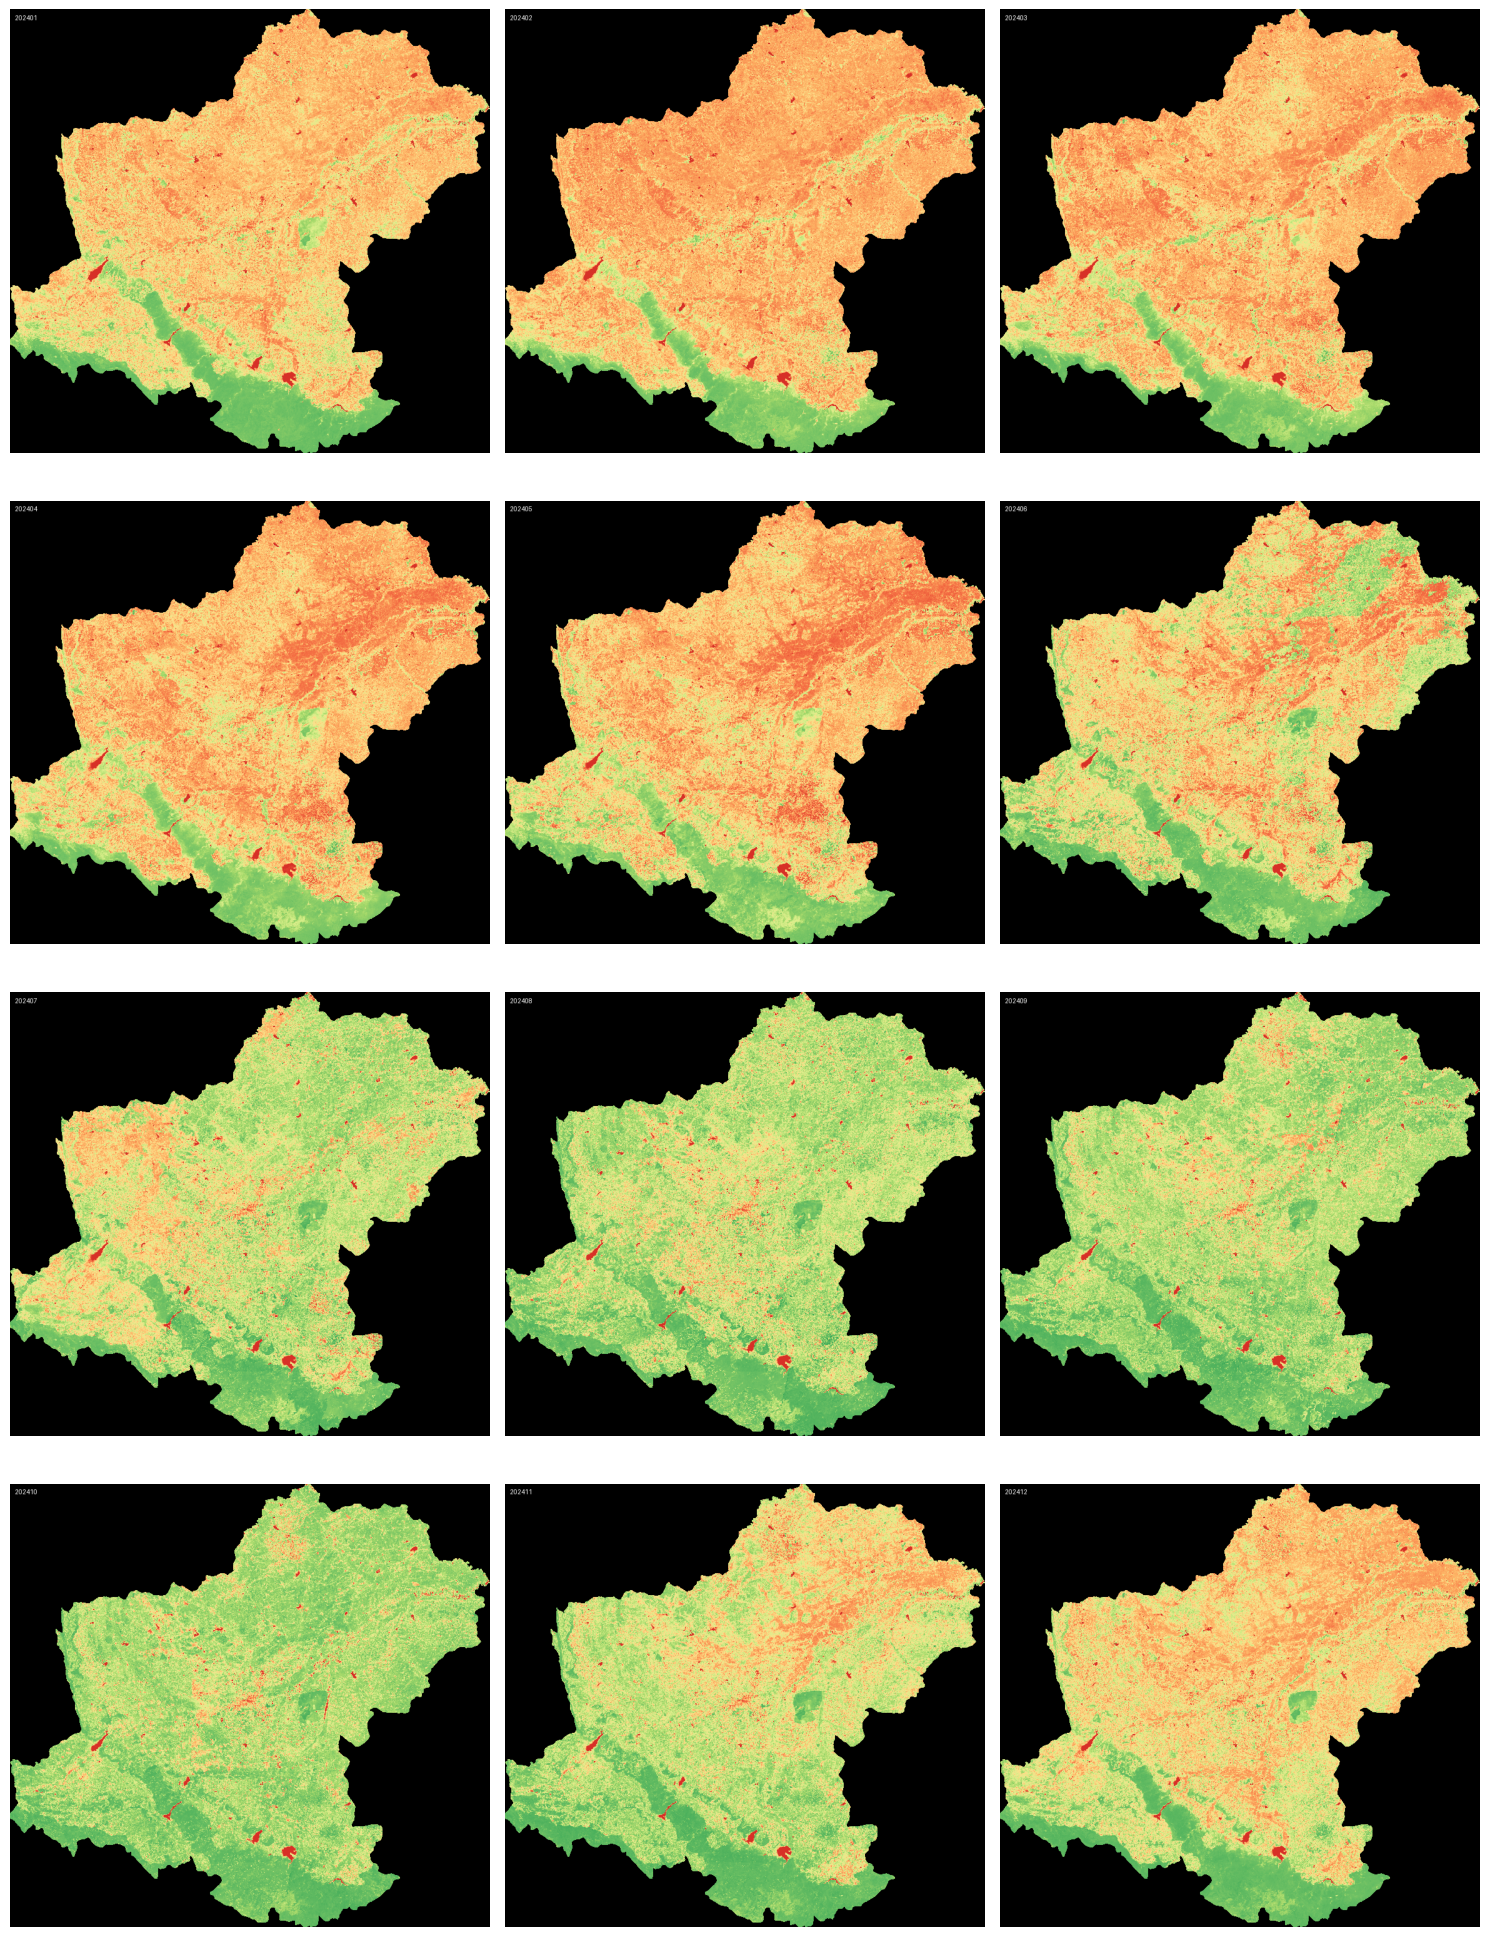

['korat_ndvi_2024_01.png',
 'korat_ndvi_2024_02.png',
 'korat_ndvi_2024_03.png',
 'korat_ndvi_2024_04.png',
 'korat_ndvi_2024_05.png',
 'korat_ndvi_2024_06.png',
 'korat_ndvi_2024_07.png',
 'korat_ndvi_2024_08.png',
 'korat_ndvi_2024_09.png',
 'korat_ndvi_2024_10.png',
 'korat_ndvi_2024_11.png',
 'korat_ndvi_2024_12.png']

In [36]:
import io, requests, calendar
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

YEAR = int(ee.Date(START_DATE).format('YYYY').getInfo())
DIM = 768
PALETTE = NDVI_VIZ['palette']

S2_SR   = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
S2_CPROB= ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

def add_cloudprob(ic_sr):
    join = ee.Join.saveFirst(matchKey='cloudmask')
    filt = ee.Filter.equals(leftField='system:index', rightField='system:index')
    joined = join.apply(ic_sr, S2_CPROB, filt)
    return ee.ImageCollection(joined)

CLOUD_PROB_TH = 40
CLOUDY_PCT_MAX = 60

def mask_s2_s2cloudless(img):
    cimg = ee.Image(img.get('cloudmask')).select('probability')
    not_cloud = cimg.lt(CLOUD_PROB_TH)

    scl = img.select('SCL')
    not_shadow = scl.neq(3)
    not_bad_scl = scl.neq(8).And(scl.neq(9)).And(scl.neq(10))

    mask = not_cloud.And(not_shadow).And(not_bad_scl)
    return img.updateMask(mask)

def to_ndvi(img):
    ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
    return ndvi.focal_median(radius=30, units='meters').copyProperties(img, img.propertyNames())

def build_month_ic(year, month, strict=True):
    start_m = ee.Date.fromYMD(year, month, 1)
    end_m   = start_m.advance(1, 'month')
    ic = (S2_SR
          .filterBounds(aoi)
          .filterDate(start_m, end_m)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUDY_PCT_MAX)))
    ic = add_cloudprob(ic)
    ic = ic.map(mask_s2_s2cloudless if strict else (lambda i: i))
    ic = ic.map(to_ndvi)
    return ic

def build_rolling_ic(year, month, window=3):
    start_m = ee.Date.fromYMD(year, month, 1)
    end_m   = start_m.advance(window, 'month')
    ic = (S2_SR
          .filterBounds(aoi)
          .filterDate(start_m, end_m)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUDY_PCT_MAX)))
    ic = add_cloudprob(ic).map(mask_s2_s2cloudless).map(to_ndvi)
    return ic

def build_annual_ic(year):
    start_y = ee.Date.fromYMD(year, 1, 1)
    end_y   = start_y.advance(1, 'year')
    def mask_relaxed(img):
        cimg = ee.Image(img.get('cloudmask')).select('probability')
        return img.updateMask(cimg.lt(60))
    ic = (S2_SR
          .filterBounds(aoi)
          .filterDate(start_y, end_y)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 90)))
    ic = add_cloudprob(ic).map(mask_relaxed).map(to_ndvi)
    return ic

annual_ic = build_annual_ic(YEAR)
annual_median = annual_ic.median().clip(aoi)

def compose_month(year, month):
    ic_m = build_month_ic(year, month, strict=True)
    primary = ee.Image(ic_m.median()).clip(aoi)

    ic_roll = build_rolling_ic(year, month, window=3)
    secondary = ee.Image(ic_roll.median()).clip(aoi)

    tertiary = annual_median

    composed = primary.unmask(secondary).unmask(tertiary).unmask(0).rename('NDVI')
    ts = ee.Date.fromYMD(year, month, 1).millis()
    return composed.set('system:time_start', ts)

def ee_to_tile(img, label):
    url = img.visualize(min=0, max=1, palette=PALETTE).getThumbURL({
        'region': aoi, 'dimensions': DIM, 'format': 'png'
    })
    r = requests.get(url); r.raise_for_status()
    im = Image.open(io.BytesIO(r.content)).convert('RGBA')

    overlay = Image.new('RGBA', im.size, (0,0,0,0))
    d = ImageDraw.Draw(overlay)
    pad = 8
    d.rectangle([0,0, 140, 34], fill=(0,0,0,150))
    d.text((pad,8), label, fill=(255,255,255,255))
    return Image.alpha_composite(im, overlay).convert('RGB')

def blank_tile(label):
    im = Image.new('RGB', (DIM, DIM), (230,230,230))
    d = ImageDraw.Draw(im)
    d.text((10,10), f"{label}\n(fallback filled)", fill=(80,80,80))
    return im

tiles, filenames = [], []
for m in range(1, 13):
    label = f"{YEAR}{m:02d}"
    img = compose_month(YEAR, m).clip(aoi)


    try:
        tile = ee_to_tile(img, label)
    except Exception:
        tile = blank_tile(label)

    fname = f"korat_ndvi_{YEAR}_{m:02d}.png"
    try:
        tile.save(fname)
        filenames.append(fname)
    except Exception:
        pass
    tiles.append(tile)

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
k = 0
for r in range(4):
    for c in range(3):
        axes[r, c].imshow(tiles[k])
        axes[r, c].axis('off')
        k += 1
plt.tight_layout()
plt.show()

filenames


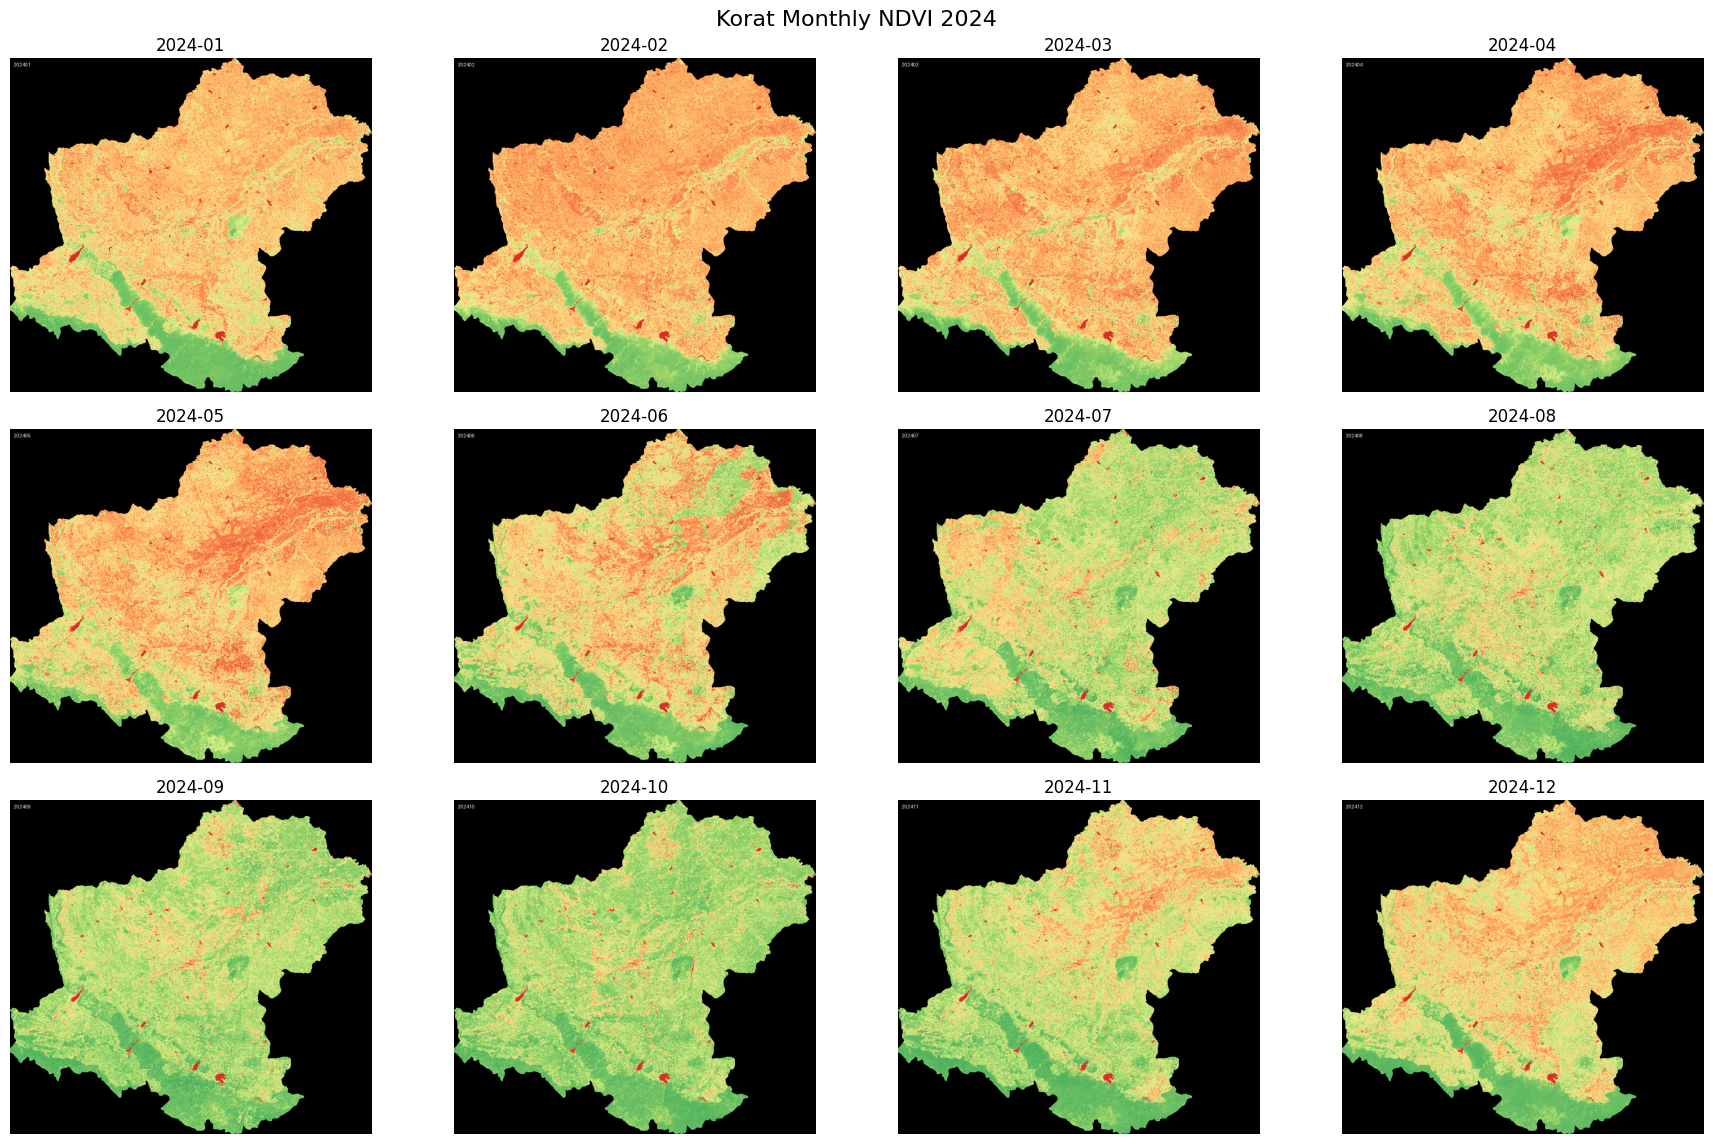

(['korat_ndvi_2024_01.png',
  'korat_ndvi_2024_02.png',
  'korat_ndvi_2024_03.png',
  'korat_ndvi_2024_04.png',
  'korat_ndvi_2024_05.png',
  'korat_ndvi_2024_06.png',
  'korat_ndvi_2024_07.png',
  'korat_ndvi_2024_08.png',
  'korat_ndvi_2024_09.png',
  'korat_ndvi_2024_10.png',
  'korat_ndvi_2024_11.png',
  'korat_ndvi_2024_12.png'],
 'korat_ndvi_panel_2024_3x4.png')

In [35]:
import matplotlib.pyplot as plt

month_labels = [f"{YEAR}-{m:02d}" for m in range(1, 13)]

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(tiles[idx])
    ax.set_title(month_labels[idx], fontsize=12)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.suptitle(f"Korat Monthly NDVI {YEAR}", fontsize=16)
panel_path = f"korat_ndvi_panel_{YEAR}_3x4.png"
fig.savefig(panel_path, dpi=200)
plt.show()

filenames, panel_path


In [25]:
import os, glob
import imageio.v2 as imageio

pattern = f"korat_ndvi_{YEAR}_*.png"
files = sorted(glob.glob(pattern))
print("Found frames:", files)

GIF_PATH = f"korat_ndvi_monthly_{YEAR}.gif"
FPS_GIF = 2

frames = [imageio.imread(fp) for fp in files]
imageio.mimsave(GIF_PATH, frames, duration=1.0/FPS_GIF, loop=0)

GIF_PATH


Found frames: ['korat_ndvi_2024_01.png', 'korat_ndvi_2024_02.png', 'korat_ndvi_2024_03.png', 'korat_ndvi_2024_04.png', 'korat_ndvi_2024_05.png', 'korat_ndvi_2024_06.png', 'korat_ndvi_2024_07.png', 'korat_ndvi_2024_08.png', 'korat_ndvi_2024_09.png', 'korat_ndvi_2024_10.png', 'korat_ndvi_2024_11.png', 'korat_ndvi_2024_12.png']


'korat_ndvi_monthly_2024.gif'